In [1]:
import librosa
import librosa.display

from scipy.signal import butter, lfilter
import numpy as np
import sklearn
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path
import csv
import json

C:\Anaconda3\miniconda3\envs\flow\lib\site-packages\ipykernel\parentpoller.py:113: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


In [41]:
DATA_SR = 128 # in Hz
AUDIO_LEN = 5  # in seconds
num_samples = AUDIO_LEN * DATA_SR


dataset_dir = Path("./datasets/ECG-kaggle-cleaned/")

In [ ]:
data = []

In [40]:
for subdataset_dir in dataset_dir.iterdir():
    if subdataset_dir.is_dir():
        print("Processing", subdataset_dir)
        with open(subdataset_dir / "RECORDS", "r") as f:
            for line in f:
                file_num = line.strip()
                data_point = np.load(subdataset_dir / (file_num + "_BEAT.npy"))
                print(data_point.shape)
                
                
                break

Processing datasets\ECG-kaggle-cleaned\incartdb_npy
Loading datasets\ECG-kaggle-cleaned\incartdb_npy\I01_BEAT.npy
(2757, 2)
Processing datasets\ECG-kaggle-cleaned\mitdb_npy
Loading datasets\ECG-kaggle-cleaned\mitdb_npy\100_BEAT.npy
(2273, 2)
Processing datasets\ECG-kaggle-cleaned\svdb_npy
Loading datasets\ECG-kaggle-cleaned\svdb_npy\800_BEAT.npy
(1883, 2)


In [94]:
test = np.load("./datasets/ECG-kaggle-cleaned/mitdb_npy/105_BEAT.npy", allow_pickle=True)
nums = np.array(test[:, 0], dtype=np.float)
labels = test[:, 1].astype(str)

nums
labels

array([1.25000e+02, 2.57000e+02, 3.86000e+02, ..., 2.30813e+05,
       2.30876e+05, 2.31037e+05])

array(['N', 'N', 'N', ..., 'V', 'V', 'N'], dtype='<U6')

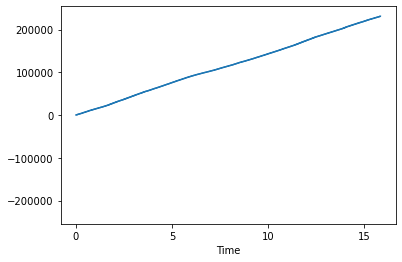

In [95]:
librosa.display.waveshow(nums, sr=DATA_SR)

# Not cleaned dataset

In [2]:
DATA_SR = 125 # in Hz

In [3]:
df_train = pd.read_csv("./datasets/ECG-kaggle/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("./datasets/ECG-kaggle/mitbih_test.csv", header=None)
df_test = df_test.sample(frac=1)

In [4]:
X_train = np.array(df_train[list(range(187))].values)
X_train = np.expand_dims(X_train, -1)
y_train = np.array(df_train[187].values).astype(np.int8)
y_train[y_train != 0] = 1 # coverting to be just normal (0) and abnormal (1)

In [5]:
X_test = np.array(df_test[list(range(187))].values)
X_test = np.expand_dims(X_test, -1)
y_test = np.array(df_test[187].values).astype(np.int8)
y_test[y_test != 0] = 1

In [6]:
set(y_train)

X_train.shape
y_train.shape
X_test.shape
y_test.shape

{0, 1}

(87554, 187, 1)

(87554,)

(21892, 187, 1)

(21892,)

In [8]:
X_train[0].shape

(187, 1)

In [11]:
X_train[0, :, 0].shape

(187,)

In [20]:
X_train.max(), X_train.min(), X_train.mean()

(1.0, 0.0, 0.174282952549064)

C:\Anaconda3\miniconda3\envs\flow\lib\site-packages\librosa\util\utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


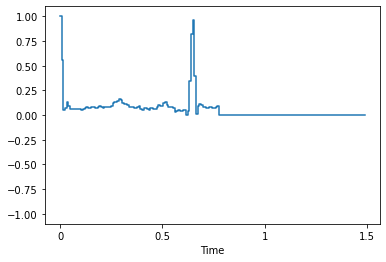

In [21]:
librosa.display.waveshow(X_train[0, :, 0], sr=DATA_SR)

In [2]:
# model_full_save = Path(
#     "./model_saves/transfer/2021-06-27_05-35-15_epochs_100-batch_size_1000-lr_0.01/full_save"
# )
model_full_save = Path(
    "./model_saves/best-0.9889_val_acc-backup/full_save"
)

test_audio_path = Path(
    "./datasets/classification-heart-sounds-physionet/training-a/a0004.wav"
)
test_set_path = Path(
    "./datasets/classification-heart-sounds-physionet/validation"
)
test_output_path = Path("./datasets/classification-heart-sounds-physionet/numpy-data/data-test.json")

In [3]:
from inference import Inference
from create_dataset import create_test_set
from clean_dataset import load_data

In [4]:
inference = Inference(
    model_full_save, 125
)  # for testing, dataset has 2kHz sample rate

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 187, 256)          133120    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 187, 128)          164352    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [5]:
# create_test_set(test_set_path, test_output_path)
X_test, y_test = load_data(test_output_path)
X_test = np.expand_dims(X_test, -1)  # add dimension to make it uniform with model input
y_test[y_test == -1] = 0  # convert to 1 for abnormal and 0 for normal

Data loaded. X shape: (4093, 187), y shape: (4093,)


In [6]:
result = inference.evaluate(X_test, y_test)

result

128/128 [==============================] - 3s 23ms/step - loss: 1.2352 - accuracy: 0.0000e+00 - binary_accuracy: 0.4977 - AUC-ROC: 0.4955 - AUC-PR: 0.5107 - precision: 0.5026 - recall: 0.6498 - true_positive: 1345.0000 - false_positive: 1331.0000 - false_negative: 725.0000 - true_negative: 692.0000


{'loss': 1.2352006435394287,
 'accuracy': 0.0,
 'binary_accuracy': 0.4976789653301239,
 'AUC-ROC': 0.49552395939826965,
 'AUC-PR': 0.5106804370880127,
 'precision': 0.5026158690452576,
 'recall': 0.6497584581375122,
 'true_positive': 1345.0,
 'false_positive': 1331.0,
 'false_negative': 725.0,
 'true_negative': 692.0,
 'f1': 0.5667931060295063,
 'sensitivity': 0.6497584541062802,
 'specificity': 0.34206623826000987}

In [7]:
audio_np, sr = librosa.load(test_audio_path, sr=125)
wav = inference.get_wav(audio_np.tolist())
print(wav)

tmp\tmp_recording.wav


In [8]:
inference.delete_wav(wav)

In [9]:
print(inference.predict(audio_np))

abnormal
